# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

Everything above this cell was a part of the previous *mission*. The current guided project will help us independently pick up from where we left and do some thorough analysis of cleaned data

<IPython.core.display.Javascript object>


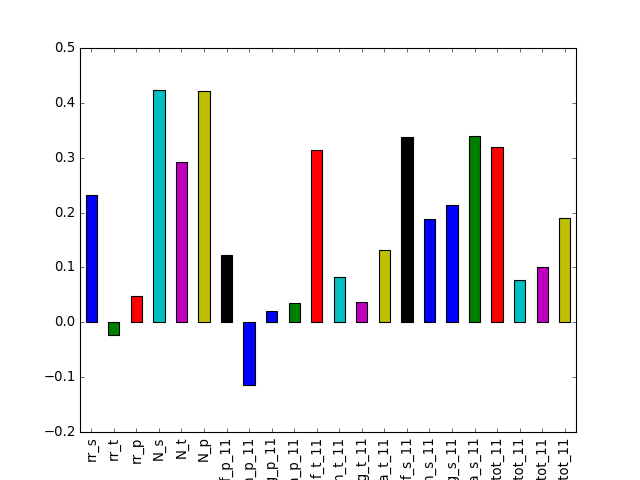

In [23]:
import matplotlib.pyplot as plt
%matplotlib notebook
correlations.loc[survey_fields].plot(kind = 'bar')

One surprising result for me was the correlation between *saf_t_11* ( safefty and respect score based on teacher response) and *saf_s_11* ( safety and respect score based on student response) with the *sat_score*. The other noticable correalations were
1. **N_s** Number of student respondents
2. **N_t** Number of teacher respondents
3. **N_p** Number of parent respondents
4. **saf_t_11** safefty and respect score based on teacher response
5. **saf_s_11** safety and respect score based on student response
6. **aca_s_11** Academic expectations score based on student responses
7. **saf_tot_11** Safety and Respect total score

<IPython.core.display.Javascript object>


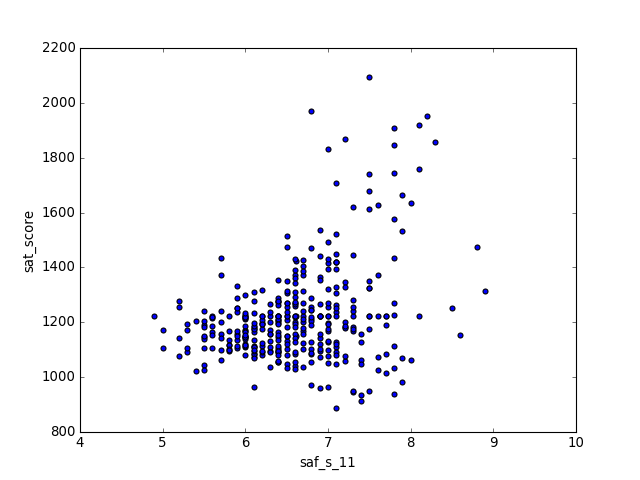

In [17]:
combined.plot.scatter( x = 'saf_s_11', y = 'sat_score')

There seems some relation between a higher score in saftely and trust vs the sat score

In [13]:
import numpy as np
districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace = True)

<IPython.core.display.Javascript object>


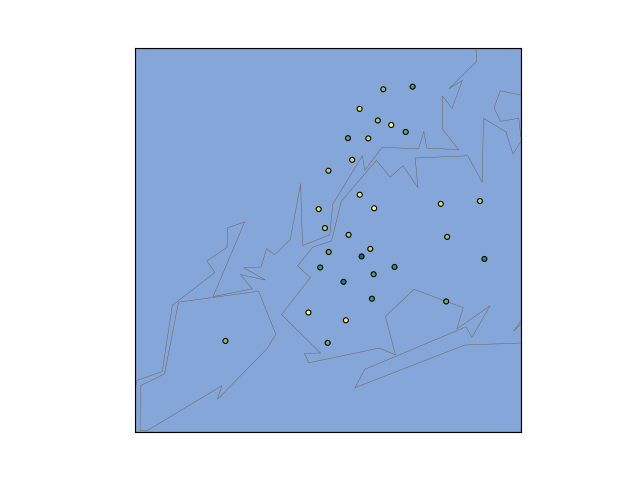

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
m = Basemap( 
    projection = 'merc',
    llcrnrlat = 40.496044,
    urcrnrlat = 40.915256,
    llcrnrlon = -74.255735,
    urcrnrlon = -73.700272,
    resolution = 'i'
    )
m.drawmapboundary(fill_color = '#85A6D9')
m.drawcoastlines(color = '#6D5F47', linewidth = 0.4)
m.drawrivers(color = '#6D5F47', linewidth = 0.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter( longitudes, latitudes, s=20, zorder = 2, latlon = True, c=districts["saf_s_11"], cmap="summer")
plt.show()

some part of manhattan and queens has high average saftely score while brooklyn has low scores

<IPython.core.display.Javascript object>


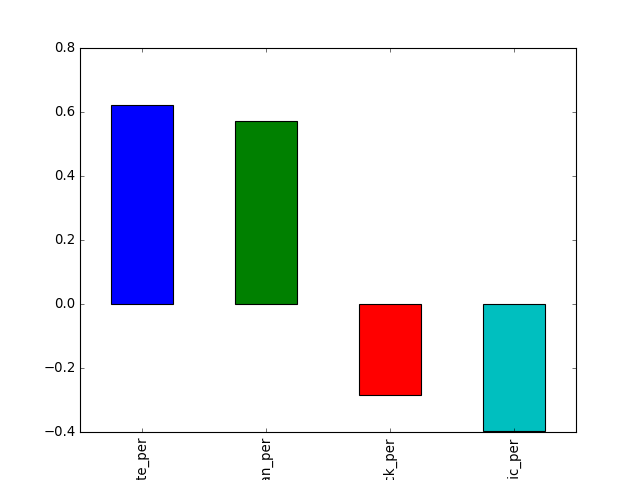

In [28]:
comm_cols = [
    'white_per',
    'asian_per',
    'black_per',
    'hispanic_per',
    ]
correlations.loc[comm_cols].plot(kind = 'bar')

Clearly, the correlations show that the test results are significantly impacted by the race percentage

<IPython.core.display.Javascript object>


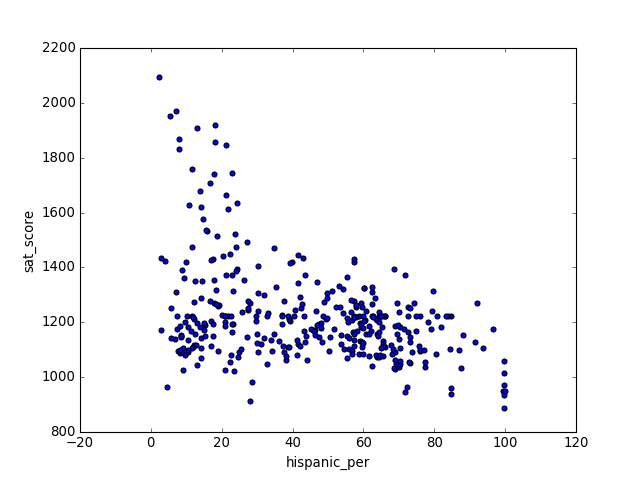

In [31]:
combined.plot.scatter( y= 'sat_score', x ='hispanic_per')

None of the schools with high test scores have a resonable percentage of hispanics. Similarly, school with majority hispanics have a low sat score

In [35]:
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Seems they are schools with majority of recent migrants who are learning english etc

In [36]:
combined[(combined['hispanic_per'] < 10) & (combined['sat_score']>1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Have a standardised test for entrance

<IPython.core.display.Javascript object>


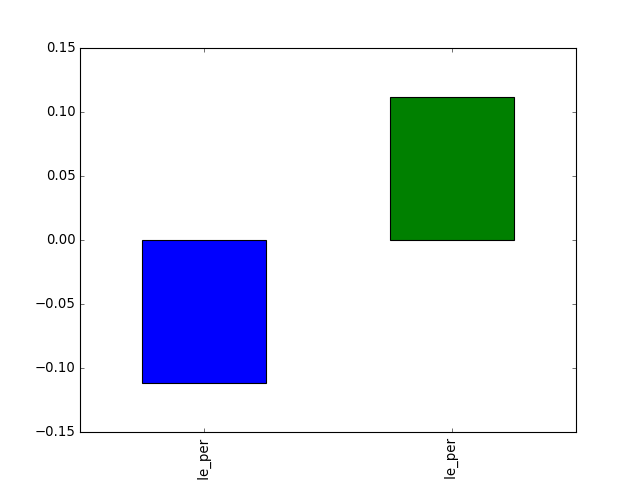

In [37]:
gen_cols = [ 'male_per', 'female_per']
correlations.loc[gen_cols].plot(kind = 'bar')

From the figures above, a higher percentage of females correlates with better sat scores while higher male percentage correlates with lower sat scores. However, these correlations are not strong.

<IPython.core.display.Javascript object>


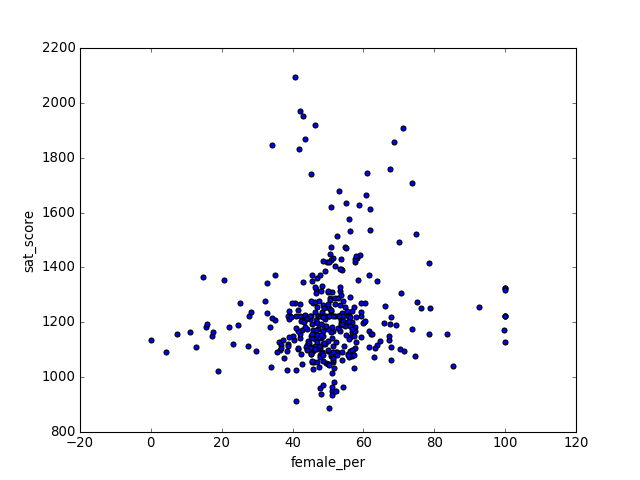

In [39]:
combined.plot.scatter(y = 'sat_score', x = 'female_per')

There isn't much correlation visible from the graphs, however, there is cluster of high female percent schools which have good sat scores

In [42]:
combined[(combined['female_per']>60) & ( combined['sat_score']>1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

liberal arts school with good academic standards

<IPython.core.display.Javascript object>


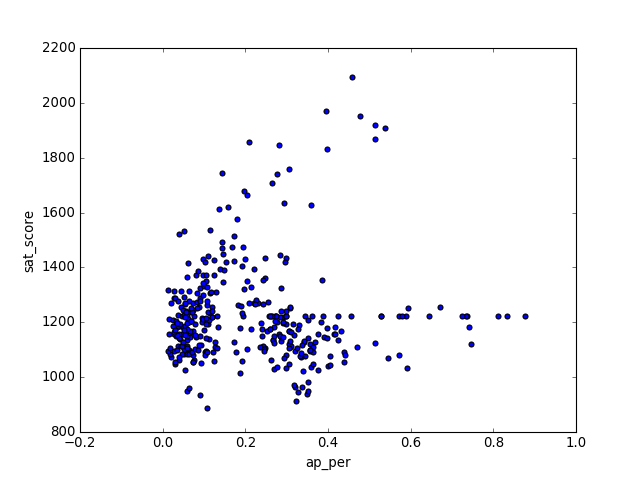

In [43]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter( x = 'ap_per', y ='sat_score')

There is some correlation betweeen AP exam taker percentage and sat scores. However, it doesn't look very strong